Embeddings shape: torch.Size([3, 100])
Attention weights shape: torch.Size([1, 4, 3, 3])


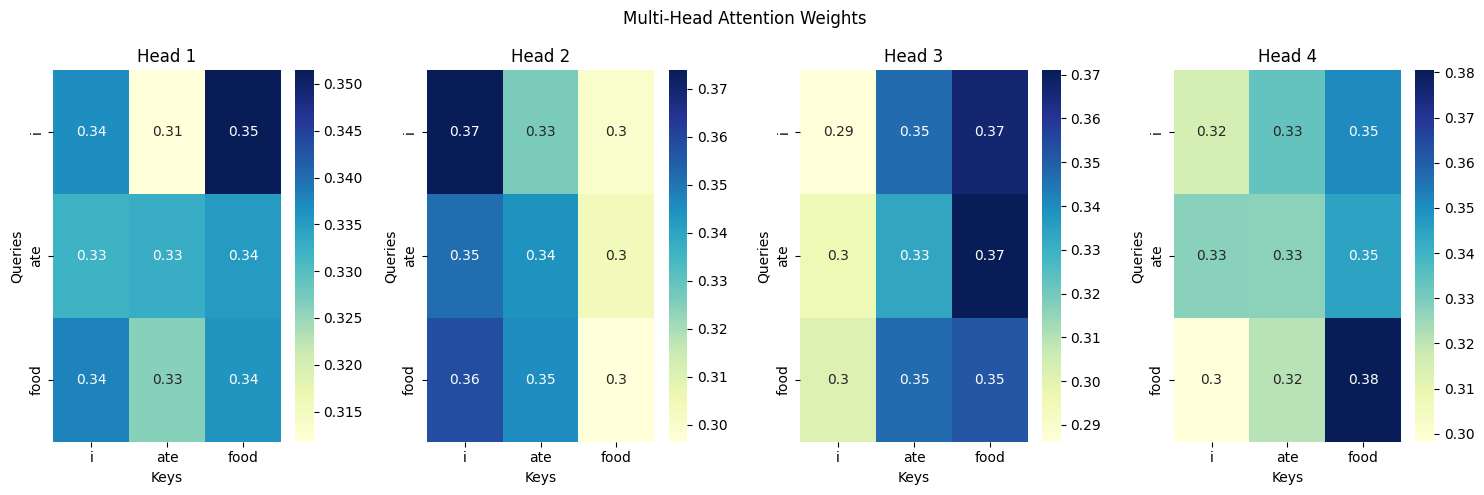

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Загружаем GloVe вручную (предполагаем, что файл 'glove.6B.100d.txt' лежит в той же папке)
def load_glove_embeddings(glove_path):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0].lower()  # Приводим к нижнему регистру
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_path = "glove.6B.100d.txt"  # Укажите ваш путь к файлу
glove_embeddings = load_glove_embeddings(glove_path)

# 2. Подготавливаем эмбеддинги для предложения
sentence = ["i", "ate", "food"]
d_model = 100  # Размерность GloVe (100 для 'glove.6B.100d.txt')

# Создаем матрицу эмбеддингов [seq_len, d_model]
embeddings = torch.tensor(np.array([glove_embeddings[word] for word in sentence]), dtype=torch.float32)
print("Embeddings shape:", embeddings.shape)  # [3, 100]

# 3. Реализуем Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.W_O = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V):
        batch_size = Q.size(0)

        # Линейные преобразования и разбиение на головы
        Q = self.W_Q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_K(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_V(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Вычисляем внимание
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        weights = F.softmax(scores, dim=-1)
        output = torch.matmul(weights, V)

        # Конкатенируем головы и применяем линейное преобразование
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.W_O(output), weights

# 4. Инициализируем Multi-Head Attention
num_heads = 4
mha = MultiHeadAttention(d_model, num_heads)

# Добавляем batch dimension (batch_size=1)
Q = embeddings.unsqueeze(0)  # [1, 3, 100]
K = embeddings.unsqueeze(0)
V = embeddings.unsqueeze(0)

# Вычисляем Multi-Head Attention
output, attention_weights = mha(Q, K, V)
print("Attention weights shape:", attention_weights.shape)  # [1, num_heads, 3, 3]

# 5. Визуализируем веса внимания для каждой головы
def plot_multihead_attention(weights, sentence, num_heads):
    fig, axes = plt.subplots(1, num_heads, figsize=(15, 5))
    for i in range(num_heads):
        sns.heatmap(
            weights[0, i].detach().numpy(),
            annot=True,
            xticklabels=sentence,
            yticklabels=sentence,
            cmap="YlGnBu",
            ax=axes[i]
        )
        axes[i].set_title(f"Head {i+1}")
        axes[i].set_xlabel("Keys")
        axes[i].set_ylabel("Queries")
    plt.suptitle("Multi-Head Attention Weights")
    plt.tight_layout()
    plt.show()

plot_multihead_attention(attention_weights, sentence, num_heads)

Head 1: Может уделять внимание связи между подлежащим и сказуемым (i → ate).

Head 2: Может фокусироваться на связи между глаголом и дополнением (ate → food).

Head 3: Может отслеживать второстепенные связи (food → i).

Head 4: Может дублировать одну из предыдущих голов или выявлять новые зависимости.



LayerNorm

In [6]:

layer_norm = nn.LayerNorm(100)
x = embeddings
output = layer_norm(x)
print(output.shape)  # [5, 10, 512]

torch.Size([3, 100])
